# Initial setup

In [412]:
#import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [413]:
#importing time series data
df = pd.read_csv('airline-passenger-traffic.csv',header = None,names =['Month','Passengers'])
df['Month'] = pd.to_datetime(df['Month'],format = "%Y-%m")
df = df.set_index('Month')
df.head()

,Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


# Time series Analysis 

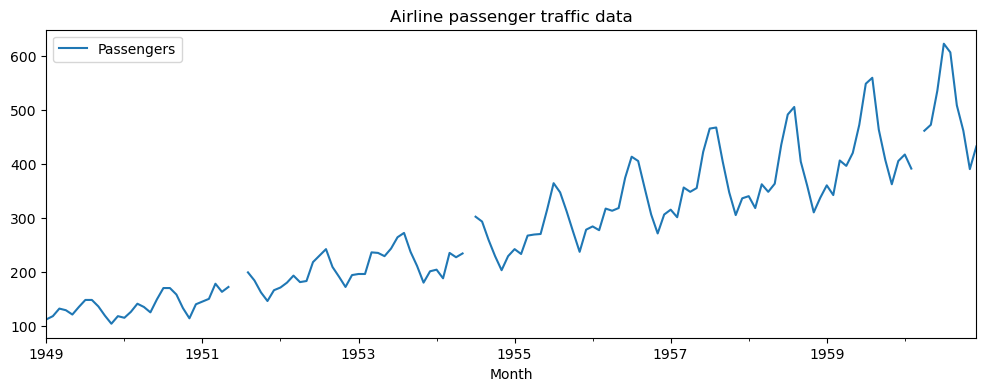

In [414]:
#plot the time series data
df.plot(figsize=(12,4))
plt.legend(loc='best')
plt.title('Airline passenger traffic data')
plt.show(block=False)

### Missing value treatment method

### Mean Imputation

In [415]:
df = df.assign(Passengers_Mean_Imputation= df.Passengers.fillna(df.Passengers.mean()))
df.head()

,Passengers,Passengers_Mean_Imputation
Month,,
1949-01-01,112.0,112.0
1949-02-01,118.0,118.0
1949-03-01,132.0,132.0
1949-04-01,129.0,129.0
1949-05-01,121.0,121.0


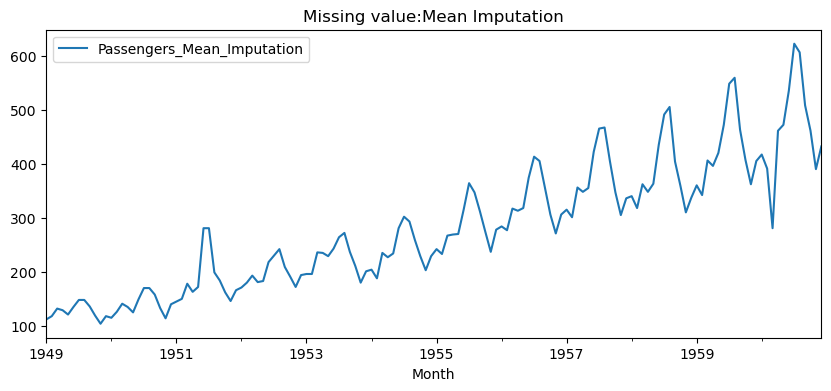

In [416]:
df['Passengers_Mean_Imputation'].plot(figsize=(10,4))
plt.legend(loc='best')
plt.title('Missing value:Mean Imputation')
plt.show(block=False)

### Linear Interpolation

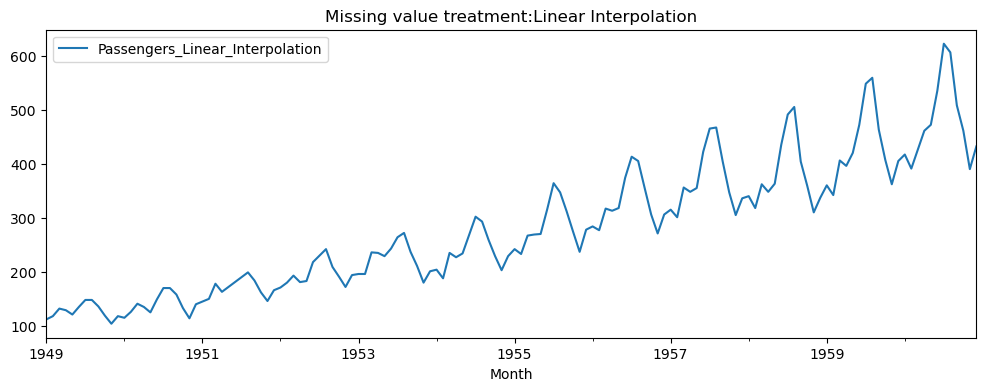

In [417]:
df = df.assign(Passengers_Linear_Interpolation=df.Passengers.interpolate(method='linear'))
df[['Passengers_Linear_Interpolation']].plot(figsize=(12,4))
plt.legend(loc='best')
plt.title('Missing value treatment:Linear Interpolation')
plt.show(block=False)

### Outlier Detection

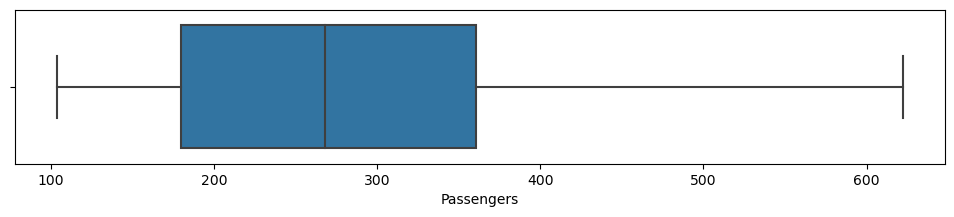

In [418]:
##Box plot and interquartile range
import seaborn as sns
fig = plt.subplots(figsize=(12,2))
ax = sns.boxplot(x =df['Passengers'],whis = 1.5) #whis is multiplicative factor with the Inter Quartile Range

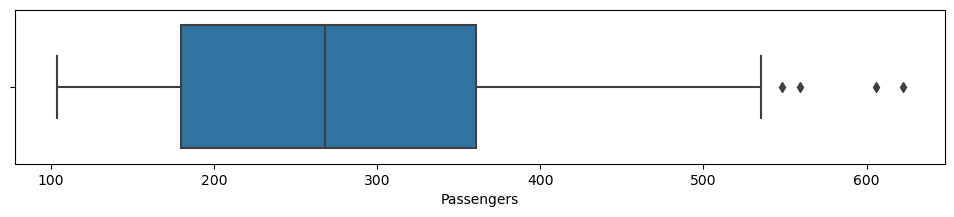

In [419]:
import seaborn as sns
fig = plt.subplots(figsize=(12,2))
ax = sns.boxplot(x =df['Passengers'],whis = 1) #whis is multiplicative factor with the Inter Quartile Range

- We can see some of the outliers here
- Conclusion-We will not treat the values beyond 540 as outliers since it is a part of the forward trend

### Plotting a histogram

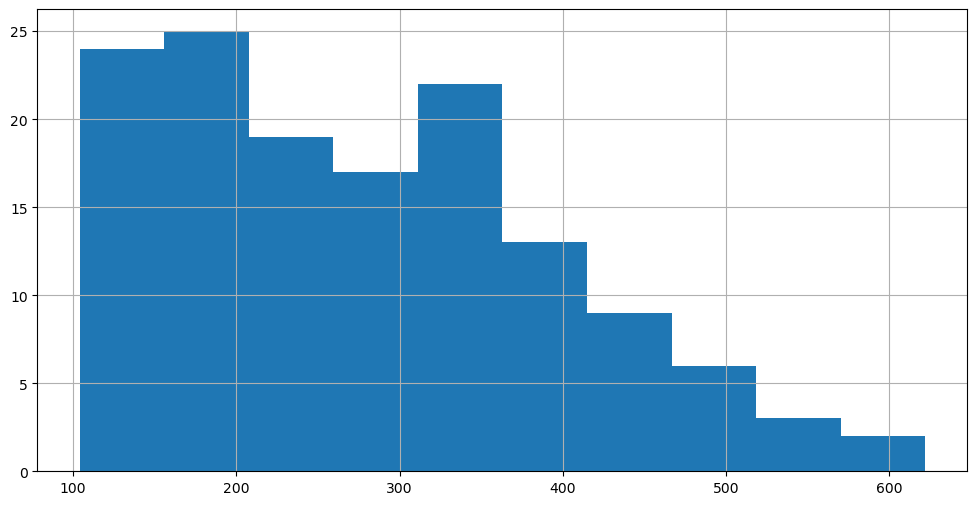

In [420]:
fig = df.Passengers.hist(figsize=(12,6))

- Since there are no discontinous values we can come to a conclusion there is no outliers in the dataset.

### Time Series decomposition 

### Additive seasonal decomposition

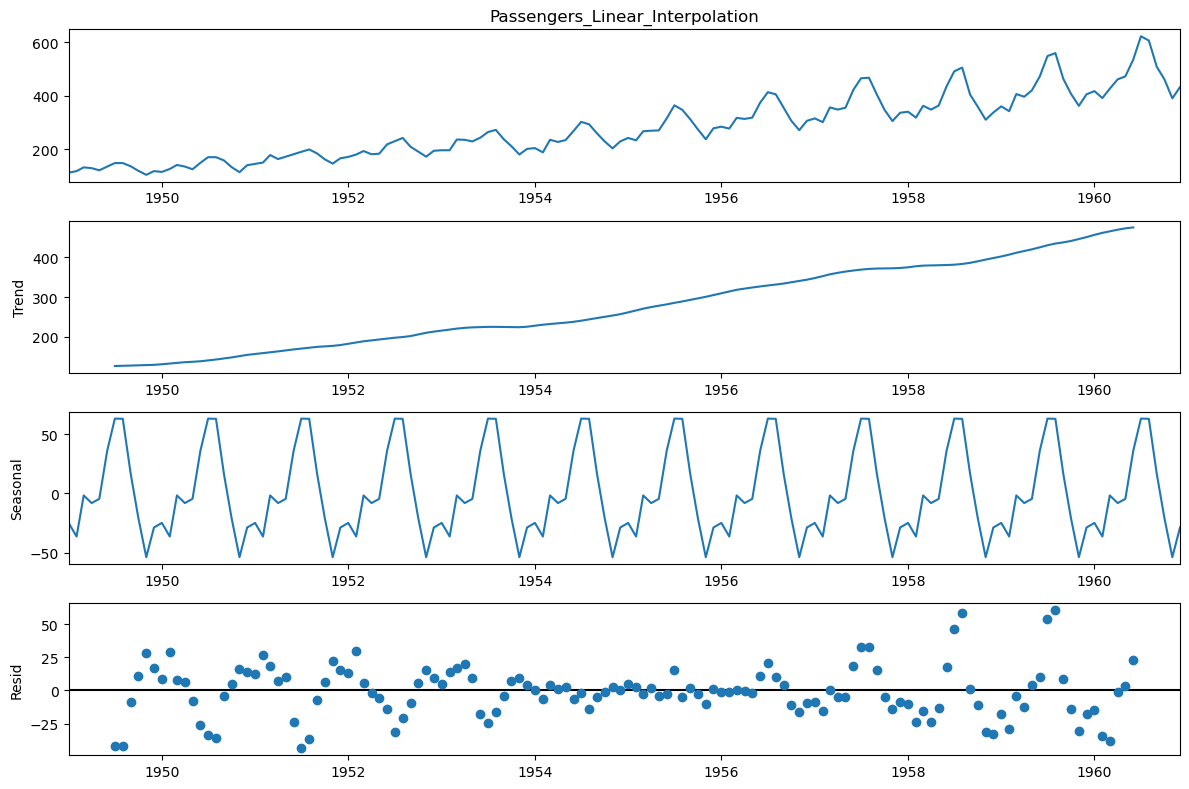

In [421]:
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize']=12,8
decomposition = sm.tsa.seasonal_decompose(df.Passengers_Linear_Interpolation,model='additive')
fig = decomposition.plot()
plt.show()

- Here we can see that the residual still follows some kind of seasonsal pattern ,therefore we can checkout for some of the other seasonal decomposition technique.

### Multiplicative seasonal decomposition

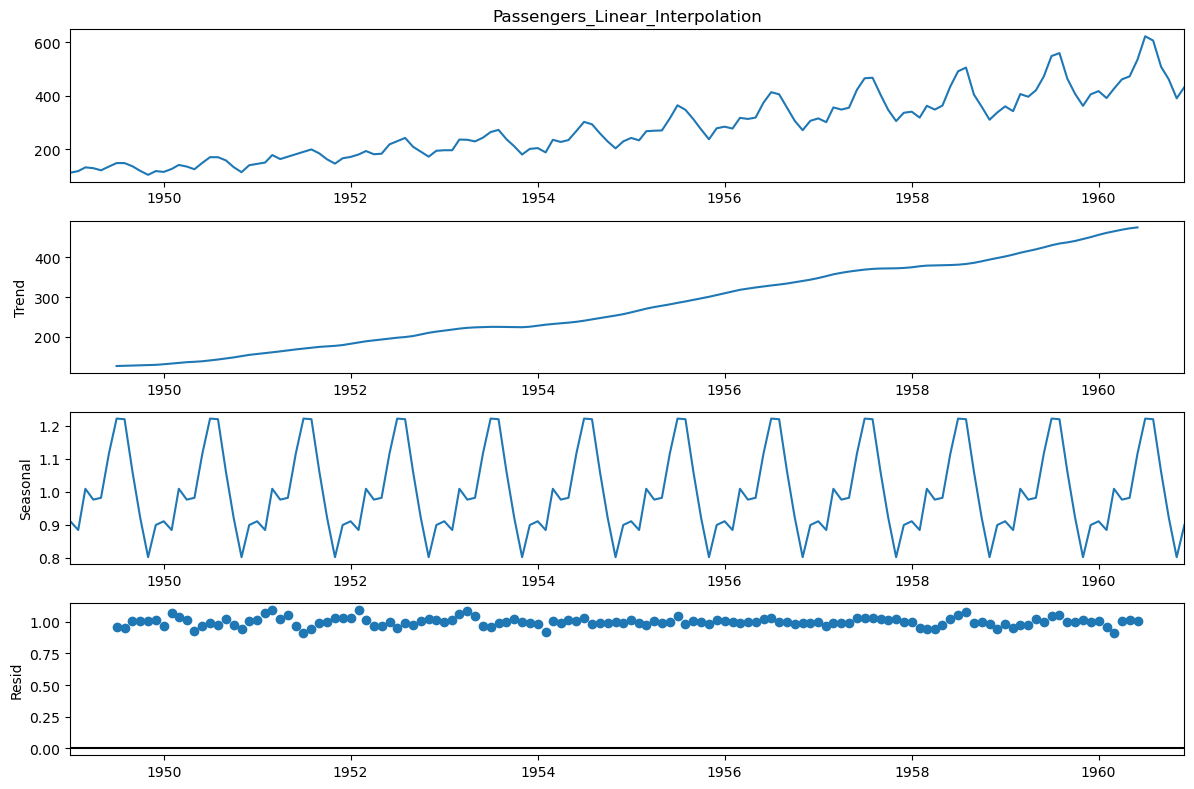

In [422]:
decomposition = sm.tsa.seasonal_decompose(df['Passengers_Linear_Interpolation'],model='multiplicative')
fig = decomposition.plot()
plt.show()

- Here we  can see residual do not have a seasonal pattern.
- Therefore we can use multiplicative seasonal decomposition to decompose the time series pattern.

### Build and evaluate time series forecast

In [423]:
#imputing Passengers_Linear_Interpolation as the value for the Passengers column
df['Passengers'] = df['Passengers_Linear_Interpolation']
df.drop(['Passengers_Mean_Imputation','Passengers_Linear_Interpolation'],axis=1,inplace=True)
df.head()

,Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


In [424]:
#splitting time series into training and test sets
train_len=120
train = df[:train_len]
test = df[train_len:]

### Naive method

In [425]:
y_hat_naive = test.copy()
y_hat_naive['naive_forecast'] = train['Passengers'][train_len-1]

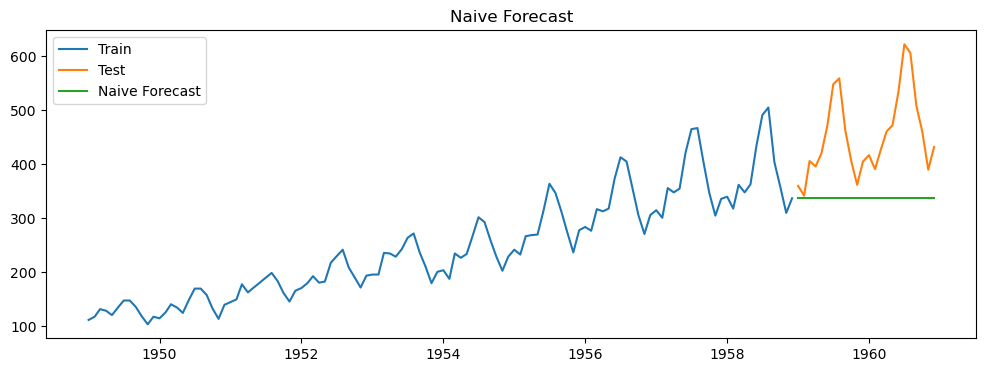

In [426]:
## plotting train,test and forecast
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'],label='Train')
plt.plot(test['Passengers'],label='Test')
plt.plot(y_hat_naive['naive_forecast'],label='Naive Forecast')
plt.title('Naive Forecast')
plt.legend(loc='best')
plt.show(block=False)

- Here we are underforecasting the value of the forecast.

### Simple Average method

In [427]:
y_hat_average = test.copy()
y_hat_average['avg_forecast'] = train['Passengers'].mean()

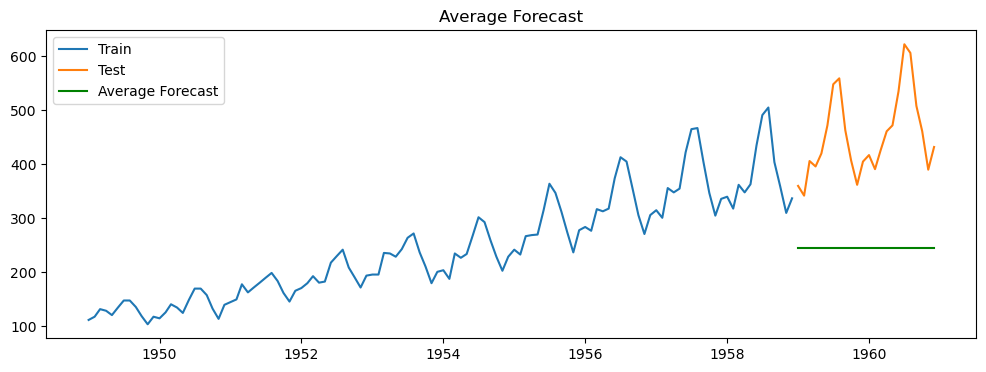

In [428]:
##plotting the graph
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'],label='Train')
plt.plot(test['Passengers'],label='Test')
plt.plot(y_hat_average['avg_forecast'],label='Average Forecast',c='g')
plt.title('Average Forecast')
plt.legend(loc='best')
plt.show(block=False)

- Here we undermining the value of the forecast considerably.
- This is also not capturing any trend or seasonality.

### Calculate the RMSE and MAPE to evaluate the error  of Naive method

In [429]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test['Passengers'],y_hat_naive['naive_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_naive['naive_forecast'])/test['Passengers'])*100,2)

results=pd.DataFrame({'Method':['Naive Method'],'MAPE':[mape],'RMSE':[rmse]})
results = results[['Method','RMSE','MAPE']]
results

,Method,RMSE,MAPE
0,Naive Method,137.51,23.63


- Because the MAPE value is 23.63% the accuracy value is 76.37%.

### Calculate the RMSE and MAPE to evaluate the error of Average Method

In [430]:
rmse = np.sqrt(mean_squared_error(test['Passengers'],y_hat_average['avg_forecast'])).round(2)
mape = round(np.mean(np.abs(test['Passengers']-y_hat_average['avg_forecast'])/test['Passengers'])*100,2)
tempResults = pd.DataFrame({'Method':['Simple Average Method'],'RMSE':[rmse],'MAPE':[mape]})
results = pd.concat([results,tempResults])
results

,Method,RMSE,MAPE
0,Naive Method,137.51,23.63
0,Simple Average Method,219.69,44.28


In [431]:
results.reset_index(drop=True,inplace=True)

In [432]:
results

,Method,RMSE,MAPE
0,Naive Method,137.51,23.63
1,Simple Average Method,219.69,44.28


# Simple moving average method

In [433]:
y_hat_sma = df.copy()
ma_window= 12
y_hat_sma['sma_forecast'] = df['Passengers'].rolling(ma_window).mean()
y_hat_sma['sma_forecast'][train_len:] = y_hat_sma['sma_forecast'][train_len-1]

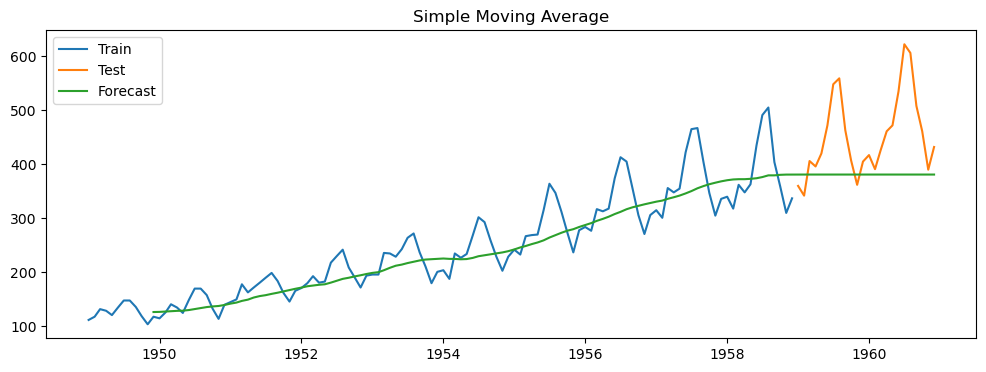

In [434]:
## Plot train,test and forecast data
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'],label='Train')
plt.plot(test['Passengers'],label='Test')
plt.plot(y_hat_sma['sma_forecast'],label='Forecast')
plt.title('Simple Moving Average')
plt.legend(loc = 'best')
plt.show(block=False)

### Calculate the RMSE and MAPE to evaluate the forecast 

In [435]:
rmse  = round(np.sqrt(mean_squared_error(test['Passengers'],y_hat_sma['sma_forecast'][train_len:])),2)
mape = round(np.mean((np.abs(test['Passengers']-y_hat_sma['sma_forecast'][train_len:]))/test['Passengers']*100),2)
tempResults = pd.DataFrame({'Method':['Simple Moving Average'],'RMSE':[rmse],'MAPE':[mape]})
results = pd.concat([results,tempResults])
results

,Method,RMSE,MAPE
0,Naive Method,137.51,23.63
1,Simple Average Method,219.69,44.28
0,Simple Moving Average,103.33,15.54


In [436]:
results.reset_index(drop=True,inplace=True)

In [437]:
results

,Method,RMSE,MAPE
0,Naive Method,137.51,23.63
1,Simple Average Method,219.69,44.28
2,Simple Moving Average,103.33,15.54


In [438]:
#changing the moving average window size to 6
y_hat_sma = df.copy()
ma_window= 6
y_hat_sma['sma_forecast'] = df['Passengers'].rolling(ma_window).mean()
y_hat_sma['sma_forecast'][train_len:] = y_hat_sma['sma_forecast'][train_len-1]

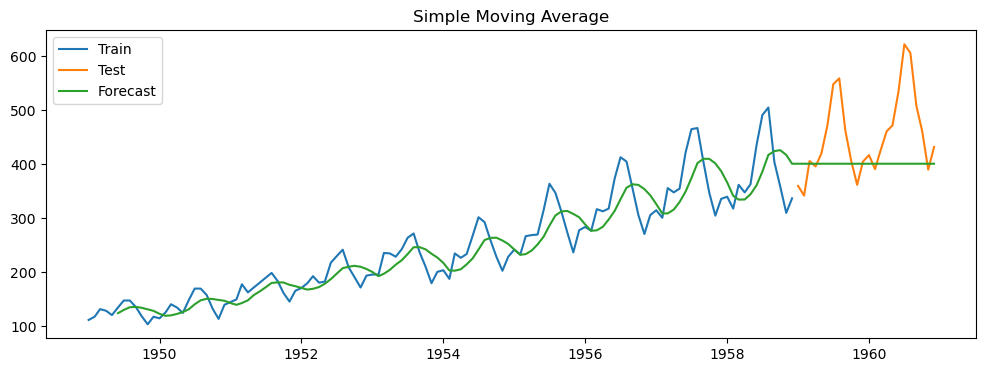

In [439]:
## Plot train,test and forecast data
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'],label='Train')
plt.plot(test['Passengers'],label='Test')
plt.plot(y_hat_sma['sma_forecast'],label='Forecast')
plt.title('Simple Moving Average')
plt.legend(loc = 'best')
plt.show(block=False)

In [440]:
#changing the moving average window size to 3
y_hat_sma = df.copy()
ma_window= 3
y_hat_sma['sma_forecast'] = df['Passengers'].rolling(ma_window).mean()
y_hat_sma['sma_forecast'][train_len:] = y_hat_sma['sma_forecast'][train_len-1]

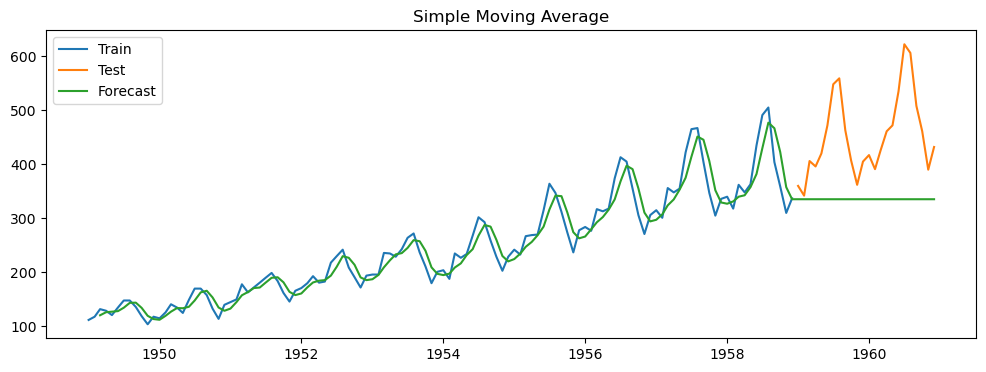

In [441]:
## Plot train,test and forecast data
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'],label='Train')
plt.plot(test['Passengers'],label='Test')
plt.plot(y_hat_sma['sma_forecast'],label='Forecast')
plt.title('Simple Moving Average')
plt.legend(loc = 'best')
plt.show(block=False)

- Here we can see that the forecast line has gotten closer to our train dataset however on the test dataset it is not performing well.
- Therefore we would move back to the moving window as 12.

### Simple Exponential Smoothing 

In [442]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
model = SimpleExpSmoothing(train['Passengers'])
model_fit = model.fit(smoothing_level=0.2,optimized=False)
print(model_fit.params)
y_hat_ses = test.copy()
y_hat_ses['ses_forecast']= model_fit.forecast(24)

{'smoothing_level': 0.2, 'smoothing_trend': None, 'smoothing_seasonal': None, 'damping_trend': nan, 'initial_level': 112.0, 'initial_trend': nan, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


In [443]:
y_hat_ses

,Passengers,ses_forecast
Month,,
1959-01-01,360.0,374.897327
1959-02-01,342.0,374.897327
1959-03-01,406.0,374.897327
1959-04-01,396.0,374.897327
1959-05-01,420.0,374.897327
1959-06-01,472.0,374.897327
1959-07-01,548.0,374.897327
1959-08-01,559.0,374.897327
1959-09-01,463.0,374.897327


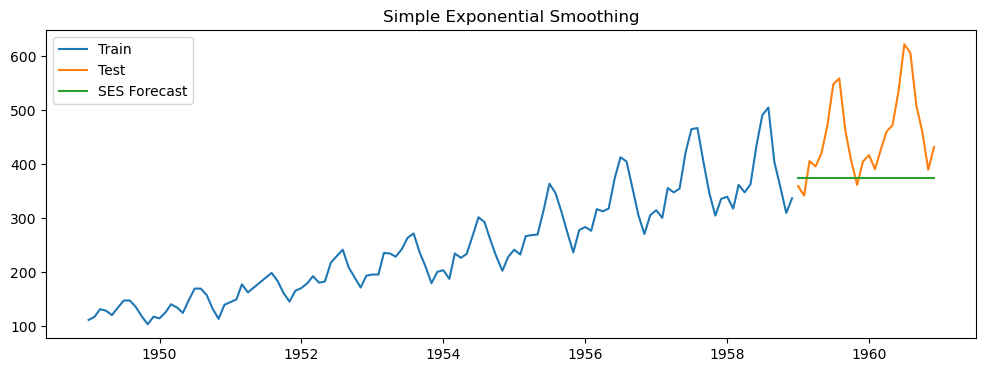

In [444]:
# Plot train, test and forecast
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'],label='Train')
plt.plot(test['Passengers'],label='Test')
plt.plot(y_hat_ses['ses_forecast'],label='SES Forecast')
plt.title('Simple Exponential Smoothing')
plt.legend(loc='best')
plt.show()

- We can the forecast captures the level of the test data and not the trend or the seasonality.

In [445]:
y_hat_ses['ses_forecast']

Month
1959-01-01    374.897327
1959-02-01    374.897327
1959-03-01    374.897327
1959-04-01    374.897327
1959-05-01    374.897327
1959-06-01    374.897327
1959-07-01    374.897327
1959-08-01    374.897327
1959-09-01    374.897327
1959-10-01    374.897327
1959-11-01    374.897327
1959-12-01    374.897327
1960-01-01    374.897327
1960-02-01    374.897327
1960-03-01    374.897327
1960-04-01    374.897327
1960-05-01    374.897327
1960-06-01    374.897327
1960-07-01    374.897327
1960-08-01    374.897327
1960-09-01    374.897327
1960-10-01    374.897327
1960-11-01    374.897327
1960-12-01    374.897327
Name: ses_forecast, dtype: float64

In [446]:
#calculate rmse and mape
rmse  = round(np.sqrt(mean_squared_error(test['Passengers'],y_hat_ses['ses_forecast'])),2)
mape = round(np.mean((np.abs(test['Passengers']-y_hat_ses['ses_forecast']))/test['Passengers']*100),2)
tempResults = pd.DataFrame({'Method':['Simple Exponential Smoothing'],'RMSE':[rmse],'MAPE':[mape]})
results = pd.concat([results,tempResults])
results

,Method,RMSE,MAPE
0,Naive Method,137.51,23.63
1,Simple Average Method,219.69,44.28
2,Simple Moving Average,103.33,15.54
0,Simple Exponential Smoothing,107.65,16.49


In [447]:
results.reset_index(drop=True,inplace=True)
results

,Method,RMSE,MAPE
0,Naive Method,137.51,23.63
1,Simple Average Method,219.69,44.28
2,Simple Moving Average,103.33,15.54
3,Simple Exponential Smoothing,107.65,16.49


# Holt's exponential smoothing method with Trend

In [448]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
model = ExponentialSmoothing(np.asarray(train['Passengers']),seasonal_periods=12,trend='additive',seasonal=None)
model_fit = model.fit(smoothing_level=0.2,smoothing_slope=0.01,optimized = False)
print(model_fit.params)
y_hat_holt = test.copy()
y_hat_holt['holt_forecast'] = model_fit.forecast(24)

{'smoothing_level': 0.2, 'smoothing_trend': 0.01, 'smoothing_seasonal': None, 'damping_trend': nan, 'initial_level': 118.4666666666666, 'initial_trend': 2.060606060606069, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


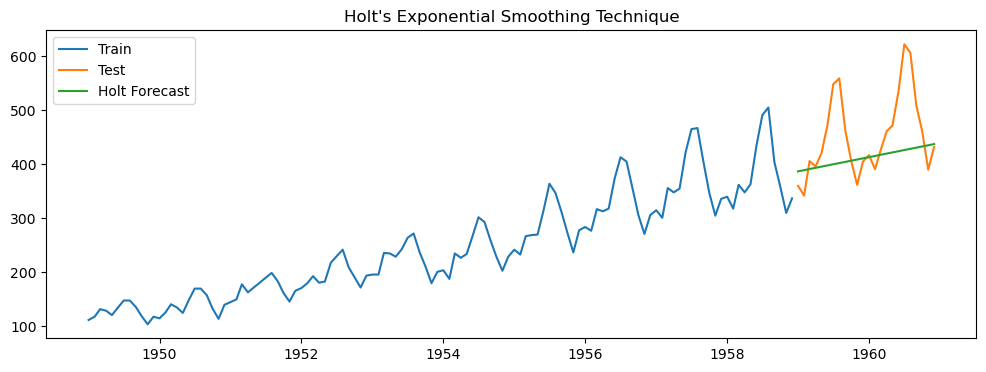

In [449]:
## Plotting train, test and forecast
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'],label='Train')
plt.plot(test['Passengers'],label='Test')
plt.plot(y_hat_holt['holt_forecast'],label='Holt Forecast')
plt.title("Holt's Exponential Smoothing Technique")
plt.legend(loc='best')
plt.show()

In [450]:
#calculating rmse and mape
rmse  = round(np.sqrt(mean_squared_error(test['Passengers'],y_hat_holt['holt_forecast'])),2)
mape = round(np.mean((np.abs(test['Passengers']-y_hat_holt['holt_forecast']))/test['Passengers']*100),2)
tempResults = pd.DataFrame({'Method':['Holts Exponential Smoothing'],'RMSE':[rmse],'MAPE':[mape]})
results = pd.concat([results,tempResults])
results

,Method,RMSE,MAPE
0,Naive Method,137.51,23.63
1,Simple Average Method,219.69,44.28
2,Simple Moving Average,103.33,15.54
3,Simple Exponential Smoothing,107.65,16.49
0,Holts Exponential Smoothing,80.91,11.39


In [451]:
results.reset_index(drop=True,inplace=True)

In [452]:
results

,Method,RMSE,MAPE
0,Naive Method,137.51,23.63
1,Simple Average Method,219.69,44.28
2,Simple Moving Average,103.33,15.54
3,Simple Exponential Smoothing,107.65,16.49
4,Holts Exponential Smoothing,80.91,11.39


### Holt Winters Additive Method with Trend and Seasonality

In [453]:
y_hat_hwa = test.copy()
model = ExponentialSmoothing(np.asarray(train['Passengers']),seasonal_periods=12,trend='add',seasonal='add')
model_fit = model.fit(optimized=True) #gets the alpha beta gamma value which will reduce the mean squared error
print(model_fit.params)
y_hat_hwa['hwa_forecast'] = model_fit.forecast(24)

{'smoothing_level': 0.2361171978116132, 'smoothing_trend': 7.679615363850196e-11, 'smoothing_seasonal': 0.7638828018270181, 'damping_trend': nan, 'initial_level': 119.14045289095831, 'initial_trend': 2.2766888689244404, 'initial_seasons': array([ -9.41693238,  -3.89040624,   8.62486483,   3.53570972,
        -5.16150036,   8.98263745,  21.24863145,  19.32984306,
         5.24250075, -13.60564542, -28.28759186, -12.13664608]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


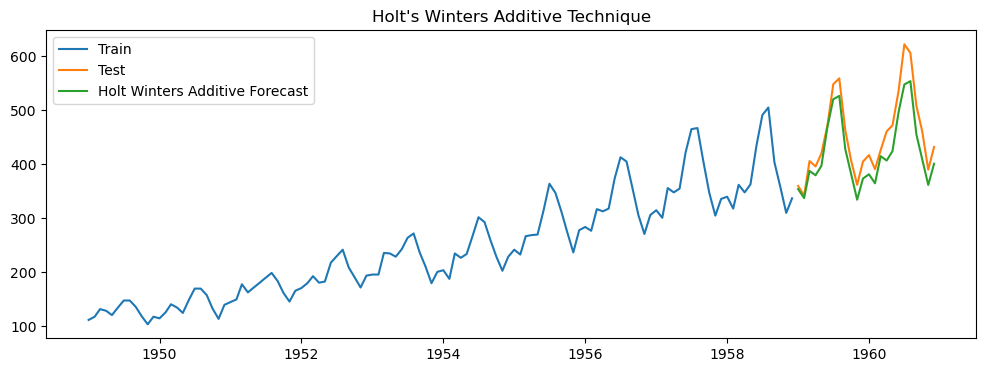

In [454]:
#Plot train,test and forecast
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'],label='Train')
plt.plot(test['Passengers'],label='Test')
plt.plot(y_hat_hwa['hwa_forecast'],label='Holt Winters Additive Forecast')
plt.title("Holt's Winters Additive Technique")
plt.legend(loc='best')
plt.show()

In [455]:
#calculate rmse and mape
rmse  = round(np.sqrt(mean_squared_error(test['Passengers'],y_hat_hwa['hwa_forecast'])),2)
mape = round(np.mean((np.abs(test['Passengers']-y_hat_hwa['hwa_forecast']))/test['Passengers']*100),2)
tempResults = pd.DataFrame({'Method':['Holts Winters Additive'],'RMSE':[rmse],'MAPE':[mape]})
results = pd.concat([results,tempResults])
results

,Method,RMSE,MAPE
0,Naive Method,137.51,23.63
1,Simple Average Method,219.69,44.28
2,Simple Moving Average,103.33,15.54
3,Simple Exponential Smoothing,107.65,16.49
4,Holts Exponential Smoothing,80.91,11.39
0,Holts Winters Additive,35.87,6.72


In [456]:
results.reset_index(drop=True,inplace=True)
results

,Method,RMSE,MAPE
0,Naive Method,137.51,23.63
1,Simple Average Method,219.69,44.28
2,Simple Moving Average,103.33,15.54
3,Simple Exponential Smoothing,107.65,16.49
4,Holts Exponential Smoothing,80.91,11.39
5,Holts Winters Additive,35.87,6.72


### Holt Winters Multiplicative Model

In [457]:
y_hat_hwam = test.copy()
model = ExponentialSmoothing(np.asarray(train['Passengers']),seasonal_periods=12,trend='add',seasonal='mul')
model_fit = model.fit(optimized=True) #gets the alpha beta gamma value which will reduce the mean squared error
print(model_fit.params)
y_hat_hwam['hwam_forecast'] = model_fit.forecast(24)

{'smoothing_level': 0.3655776181336739, 'smoothing_trend': 7.000160790713375e-07, 'smoothing_seasonal': 0.6344221915208443, 'damping_trend': nan, 'initial_level': 100.91058555806529, 'initial_trend': 2.1854790058193623, 'initial_seasons': array([1.08633829, 1.14268054, 1.25600203, 1.19404046, 1.10209938,
       1.205238  , 1.31063023, 1.30172641, 1.18746833, 1.03480496,
       0.91994195, 1.06136388]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


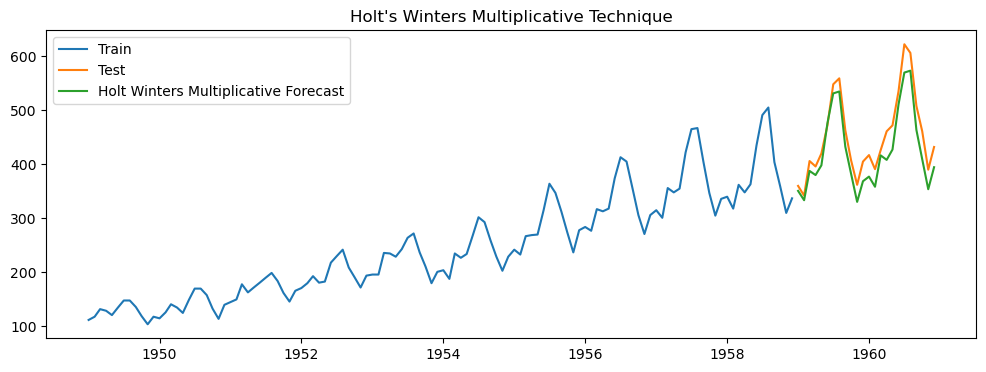

In [458]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'],label='Train')
plt.plot(test['Passengers'],label='Test')
plt.plot(y_hat_hwam['hwam_forecast'],label='Holt Winters Multiplicative Forecast')
plt.title("Holt's Winters Multiplicative Technique")
plt.legend(loc='best')
plt.show()

In [459]:
#calculate rmse and mape
rmse  = round(np.sqrt(mean_squared_error(test['Passengers'],y_hat_hwam['hwam_forecast'])),2)
mape = round(np.mean((np.abs(test['Passengers']-y_hat_hwam['hwam_forecast']))/test['Passengers']*100),2)
tempResults = pd.DataFrame({'Method':['Holts Winters Multiplicative'],'RMSE':[rmse],'MAPE':[mape]})
results = pd.concat([results,tempResults])
results

,Method,RMSE,MAPE
0,Naive Method,137.51,23.63
1,Simple Average Method,219.69,44.28
2,Simple Moving Average,103.33,15.54
3,Simple Exponential Smoothing,107.65,16.49
4,Holts Exponential Smoothing,80.91,11.39
5,Holts Winters Additive,35.87,6.72
0,Holts Winters Multiplicative,32.45,6.45


In [460]:
results.reset_index(drop=True,inplace=True)

In [461]:
results

,Method,RMSE,MAPE
0,Naive Method,137.51,23.63
1,Simple Average Method,219.69,44.28
2,Simple Moving Average,103.33,15.54
3,Simple Exponential Smoothing,107.65,16.49
4,Holts Exponential Smoothing,80.91,11.39
5,Holts Winters Additive,35.87,6.72
6,Holts Winters Multiplicative,32.45,6.45


# Auto Regressive Models 

### Stationary vs Non Stationary time series

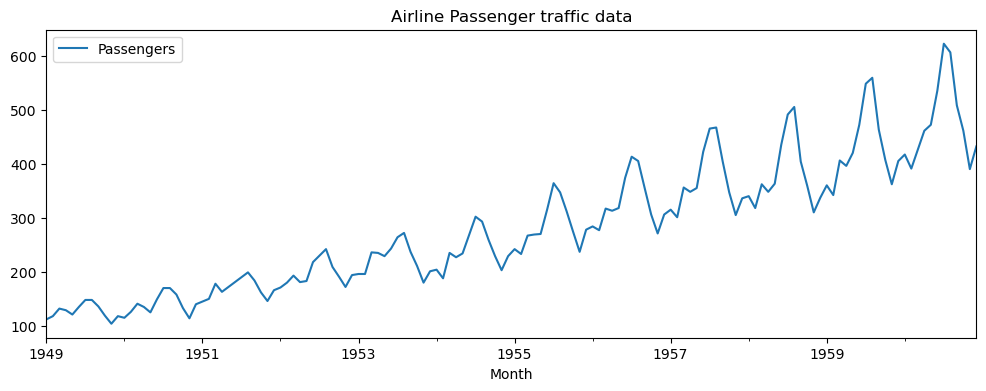

In [462]:
#time series plot
df['Passengers'].plot(figsize=(12,4))
plt.legend(loc='best')
plt.title('Airline Passenger traffic data')
plt.show()

- In this case it is quite evident that there is a trend and the time series data should not be stationary.
- The variance is also varying and not constant.
- We can now look at the ADF test to have a clear understanding.

### ADF test- Augmented Dickey Fuller Test 

In [463]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(df['Passengers'])
print('ADF statistic: %f' %adf_test[0])
print('Critical value @ 0.05: %.2f' %adf_test[4]['5%'])
print('p-value: %f' %adf_test[1])

ADF statistic: 0.894609
Critical value @ 0.05: -2.88
p-value: 0.993020


- Here since we are failing to reject the null hypothesis the time series is not stationary.

### KPSS test

In [464]:
from statsmodels.tsa.stattools import kpss
kpss_test = kpss(df['Passengers'])

print('KPSS statistic %f:'%kpss_test[0])
print('Critical value @ 0.05: %0.2f'%kpss_test[3]['5%'])
print('p-value:%f' %kpss_test[1])

KPSS statistic 1.651190:
Critical value @ 0.05: 0.46
p-value:0.010000


### Box cox transformation

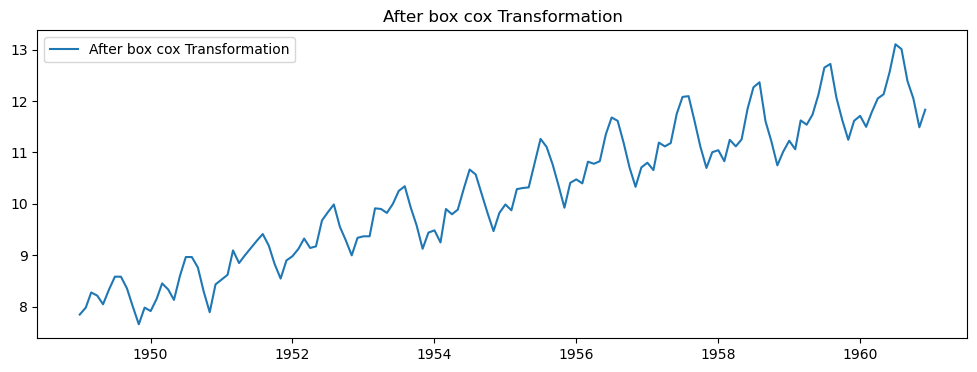

In [465]:
from scipy.stats import boxcox
df_boxcox=pd.Series(boxcox(df['Passengers'],lmbda=0.2),index= df.index)
plt.figure(figsize=(12,4))
plt.plot(df_boxcox, label= 'After box cox Transformation')
plt.legend(loc='best')
plt.title('After box cox Transformation')
plt.show()

- Here we can see that the variance is not constant however there is still trend in it.
- Let's use differencing now.

## Differencing

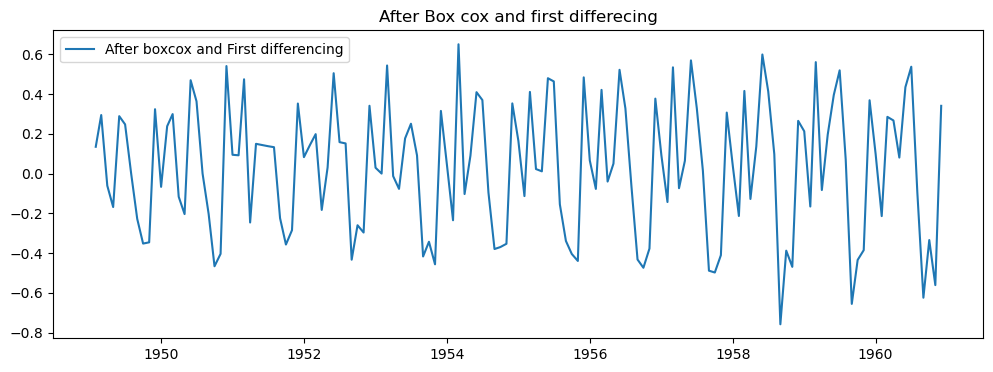

In [466]:
df_boxcox_diff = pd.Series(df_boxcox - df_boxcox.shift(),index = df.index)
df_boxcox_diff.dropna(inplace=True)

plt.figure(figsize=(12,4))
plt.plot(df_boxcox_diff,label = 'After boxcox and First differencing')
plt.title('After Box cox and first differecing')
plt.legend(loc='best')
plt.show(block=False)

- Here we can see the mean of the data is constant.

### ADF test 

In [467]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(df_boxcox_diff)
print('ADF statistic: %f' %adf_test[0])
print('Critical value @ 0.05: %.2f' %adf_test[4]['5%'])
print('p-value: %f' %adf_test[1])

ADF statistic: -3.384629
Critical value @ 0.05: -2.88
p-value: 0.011494


- Here we can reject null hypothesis and the series is stationary.

### KPSS test

In [468]:
from statsmodels.tsa.stattools import kpss
kpss_test = kpss(df_boxcox_diff)

print('KPSS statistic %f:'%kpss_test[0])
print('Critical value @ 0.05: %0.2f'%kpss_test[3]['5%'])
print('p-value:%f' %kpss_test[1])

KPSS statistic 0.030443:
Critical value @ 0.05: 0.46
p-value:0.100000


Here we fail to reject the null hypothesis and the series is stationary.(check the p value)

In [469]:
pd.DataFrame({'0':[1,0],'1':[0,1]}).corr()

,0,1
0,1.0,-1.0
1,-1.0,1.0


### Autocorrelation Function(ACF) plot

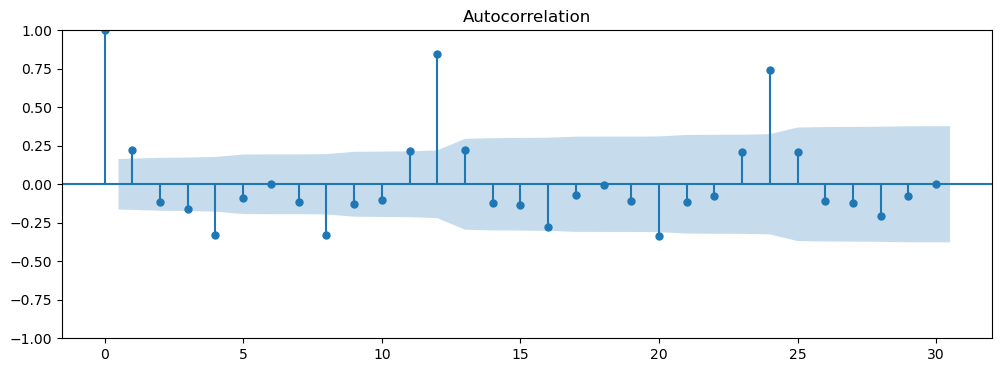

In [470]:
from statsmodels.graphics.tsaplots import plot_acf
plt.figure(figsize=(12,4))
plot_acf(df_boxcox_diff,ax = plt.gca(),lags = 30)
plt.show()

- We can see that 1,4,8 lags have a significant autocorrelation.

### Partial autocorrelated function(PACF) plot

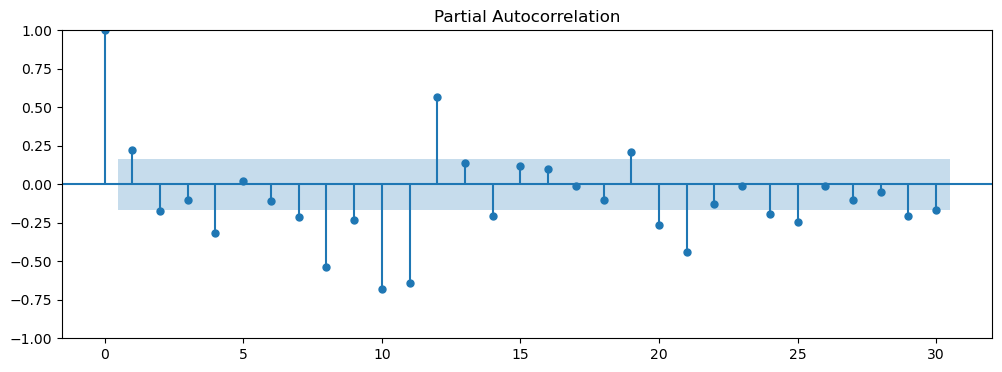

In [471]:
from statsmodels.graphics.tsaplots import plot_pacf

plt.figure(figsize=(12,4))
plot_pacf(df_boxcox_diff,ax =plt.gca(),lags=30)
plt.show()

In [472]:
#splitting into train and test datasets
train_df_boxcox = df_boxcox[:train_len]
test_df_boxcox = df_boxcox[train_len:]
train_df_boxcox_diff = df_boxcox_diff[:train_len-1]
test_df_boxcox_diff = df_boxcox_diff[train_len-1:]

### Auto Regression method(AR) 

In [473]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train_df_boxcox_diff,order=(1,0,0))
model_fit = model.fit()
print(model_fit.params)

const     0.027348
ar.L1     0.204139
sigma2    0.095073
dtype: float64


### Recover original time series forecast

In [474]:
y_hat_ar = df_boxcox_diff.copy()  #box cox and 1st difference dataset
y_hat_ar['ar_forecast_boxcox_diff'] = model_fit.predict(start=df_boxcox_diff.index.min(),end= df_boxcox_diff.index.max())
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox_diff'].cumsum()
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox'].add(df_boxcox[0])
#inversing box cox transformation
from scipy.special import inv_boxcox
y_hat_ar['ar_forecast'] = inv_boxcox(y_hat_ar['ar_forecast_boxcox'],0.2)

### Plot train,test and forecast

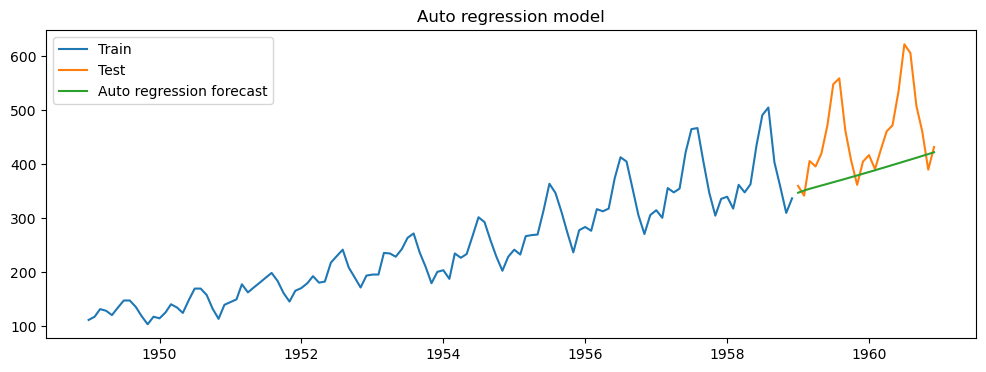

In [475]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'],label='Train')
plt.plot(test['Passengers'],label='Test')
plt.plot(y_hat_ar['ar_forecast'][test.index.min():],label = 'Auto regression forecast')
plt.legend(loc='best')
plt.title('Auto regression model')
plt.show(block=False)

- Here the trend has been captured however seasonality is not.

In [476]:
## Checking out the rmse and mape
rmse  = round(np.sqrt(mean_squared_error(test['Passengers'],y_hat_ar['ar_forecast'][test.index.min():])),2)
mape = round(np.mean((np.abs(test['Passengers']-y_hat_ar['ar_forecast'][test.index.min():]))/test['Passengers']*100),2)
tempResults = pd.DataFrame({'Method':['Simple Auto Regression(AR)'],'RMSE':[rmse],'MAPE':[mape]})
results = pd.concat([results,tempResults])
results.reset_index(drop=True,inplace=True)
results

,Method,RMSE,MAPE
0,Naive Method,137.51,23.63
1,Simple Average Method,219.69,44.28
2,Simple Moving Average,103.33,15.54
3,Simple Exponential Smoothing,107.65,16.49
4,Holts Exponential Smoothing,80.91,11.39
5,Holts Winters Additive,35.87,6.72
6,Holts Winters Multiplicative,32.45,6.45
7,Simple Auto Regression(AR),96.97,14.43


### Moving Average(MA)

In [586]:
model = ARIMA(df_boxcox_diff,order = (0,0,1))
model_fit= model.fit()

print(model_fit.params)

const     0.028908
ma.L1     0.306007
sigma2    0.098982
dtype: float64


### Recovering original time series forecast 

In [595]:
y_hat_ma = df_boxcox_diff.copy()
y_hat_ma['ma_forecast_boxcox_diff'] = model_fit.predict(df_boxcox_diff.index.min(),df_boxcox_diff.index.max())
y_hat_ma['ma_forecast_boxcox'] = y_hat_ma['ma_forecast_boxcox_diff'].cumsum()
y_hat_ma['ma_forecast_boxcox'] = y_hat_ma['ma_forecast_boxcox'].add(df_boxcox[0])
y_hat_ma['ma_forecast'] = inv_boxcox(y_hat_ma['ma_forecast_boxcox'],0.2)  #inverse boxcox

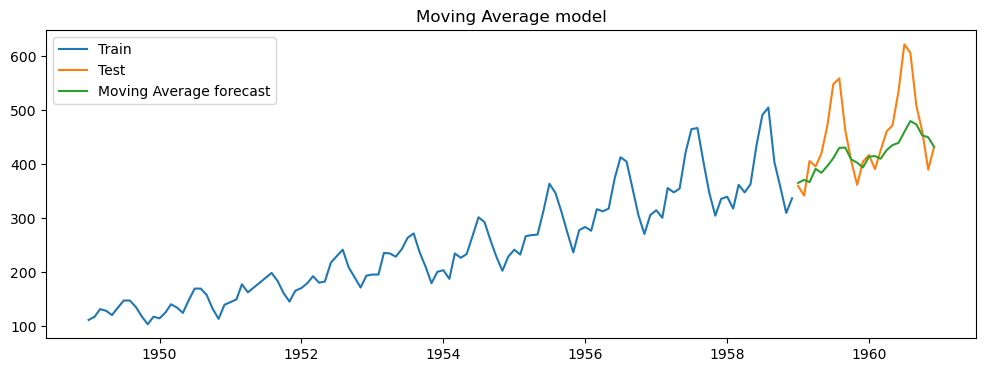

In [596]:
#Plotting the graph
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'],label='Train')
plt.plot(test['Passengers'],label='Test')
plt.plot(y_hat_ma['ma_forecast'][test.index.min():],label = 'Moving Average forecast')
plt.legend(loc='best')
plt.title('Moving Average model')
plt.show(block=False)

- In case of our MA(1) model we can see certain bit of trend and seasonality has been captured.

In [480]:
##rmse and mape
rmse  = round(np.sqrt(mean_squared_error(test['Passengers'],y_hat_ma['ma_forecast'][test.index.min():])),2)
mape = round(np.mean((np.abs(test['Passengers']-y_hat_ma['ma_forecast'][test.index.min():]))/test['Passengers']*100),2)
tempResults = pd.DataFrame({'Method':['Moving Average(MA)'],'RMSE':[rmse],'MAPE':[mape]})
results = pd.concat([results,tempResults])
results.reset_index(drop=True,inplace=True)
results

,Method,RMSE,MAPE
0,Naive Method,137.51,23.63
1,Simple Average Method,219.69,44.28
2,Simple Moving Average,103.33,15.54
3,Simple Exponential Smoothing,107.65,16.49
4,Holts Exponential Smoothing,80.91,11.39
5,Holts Winters Additive,35.87,6.72
6,Holts Winters Multiplicative,32.45,6.45
7,Simple Auto Regression(AR),96.97,14.43
8,Moving Average(MA),66.74,9.54


### Auto Regressive moving average(ARMA) method 

In [481]:
model =ARIMA(train_df_boxcox_diff,order = (1,0,1))
model_fit = model.fit()

print(model_fit.params)

const     0.027912
ar.L1    -0.518288
ma.L1     0.810691
sigma2    0.089140
dtype: float64


In [482]:
#Recover the original time series forecast
y_hat_arma = df_boxcox_diff.copy()
y_hat_arma['arma_boxcox_diff'] = model_fit.predict(df_boxcox_diff.index.min(),df_boxcox_diff.index.max())
y_hat_arma['arma_boxcox'] = y_hat_arma['arma_boxcox_diff'].cumsum()
y_hat_arma['arma_boxcox'] = y_hat_arma['arma_boxcox'].add(df_boxcox[0])

#inverse boxcox transformation
y_hat_arma['arma_forecast'] = inv_boxcox(y_hat_arma['arma_boxcox'],0.2)

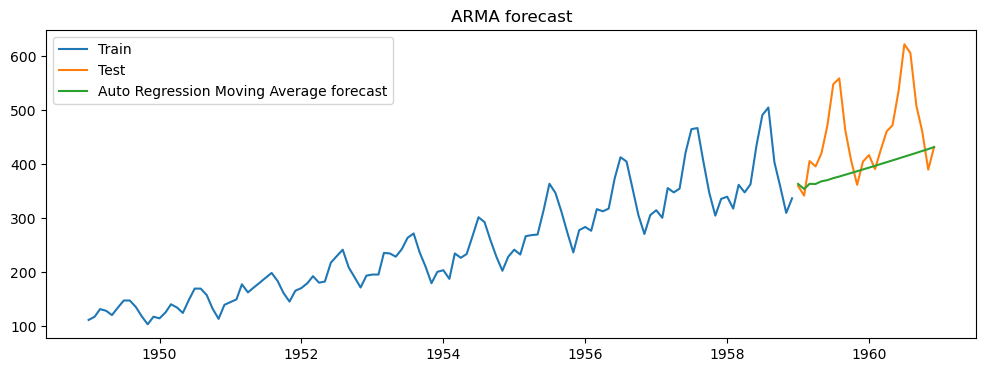

In [483]:
#Plotting train, test and forecast
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'],label='Train')
plt.plot(test['Passengers'],label='Test')
plt.plot(y_hat_arma['arma_forecast'][test.index.min():],label = 'Auto Regression Moving Average forecast')
plt.legend(loc='best')
plt.title('ARMA forecast')
plt.show(block=False)

- ARMA model is underforecasting and not capturing any trend here.

In [484]:
##rmse and mape
rmse  = round(np.sqrt(mean_squared_error(test['Passengers'],y_hat_arma['arma_forecast'][test.index.min():])),2)
mape = round(np.mean((np.abs(test['Passengers']-y_hat_arma['arma_forecast'][test.index.min():]))/test['Passengers']*100),2)
tempResults = pd.DataFrame({'Method':['ARMA Method'],'RMSE':[rmse],'MAPE':[mape]})
results = pd.concat([results,tempResults])
results.reset_index(drop=True,inplace=True)
results

,Method,RMSE,MAPE
0,Naive Method,137.51,23.63
1,Simple Average Method,219.69,44.28
2,Simple Moving Average,103.33,15.54
3,Simple Exponential Smoothing,107.65,16.49
4,Holts Exponential Smoothing,80.91,11.39
5,Holts Winters Additive,35.87,6.72
6,Holts Winters Multiplicative,32.45,6.45
7,Simple Auto Regression(AR),96.97,14.43
8,Moving Average(MA),66.74,9.54
9,ARMA Method,91.38,13.21


### Auto regressive integrated moving average (ARIMA) Method 

In [485]:
model= ARIMA(train_df_boxcox,order = (1,1,1))
model_fit = model.fit()
print(model_fit.params)

ar.L1    -0.513798
ma.L1     0.808809
sigma2    0.089687
dtype: float64


### Recover original time series forecast

In [528]:
y_hat_arima = df_boxcox_diff.copy()
y_hat_arima['arima_boxcox_diff'] = model_fit.predict(df_boxcox_diff.index.min(),df_boxcox_diff.index.max())
y_hat_arima['arima_boxcox'] = y_hat_arima['arima_boxcox_diff'].cumsum()
y_hat_arima['arima_boxcox'] = y_hat_arima['arima_boxcox'].add(df_boxcox[0])

#inverse boxcox transformation
y_hat_arima['arima_forecast'] = inv_boxcox(y_hat_arima['arima_boxcox'],1.2)

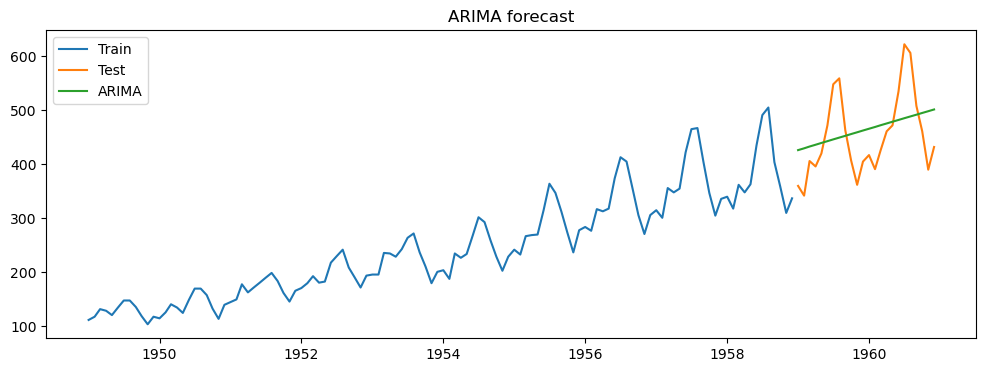

In [529]:
#Plotting train, test and forecast
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'],label='Train')
plt.plot(test['Passengers'],label='Test')
plt.plot(y_hat_arima['arima_forecast'][test.index.min():],label = 'ARIMA')
plt.legend(loc='best')
plt.title('ARIMA forecast')
plt.show(block=False)

- By changing up the lambda value in inv_boxcox transformation the ARIMA model seems to have forecasted the trend correctly.
- No seasonality appearing in case of the forecast.

In [525]:
##rmse and mape
rmse  = round(np.sqrt(mean_squared_error(test['Passengers'],y_hat_arima['arima_forecast'][test.index.min():])),2)
mape = round(np.mean((np.abs(test['Passengers']-y_hat_arima['arima_forecast'][test.index.min():]))/test['Passengers']*100),2)
tempResults = pd.DataFrame({'Method':['ARIMA Method'],'RMSE':[rmse],'MAPE':[mape]})
results = pd.concat([results,tempResults])
results.reset_index(drop=True,inplace=True)
results

,Method,RMSE,MAPE
0,Naive Method,137.51,23.63
1,Simple Average Method,219.69,44.28
2,Simple Moving Average,103.33,15.54
3,Simple Exponential Smoothing,107.65,16.49
4,Holts Exponential Smoothing,80.91,11.39
5,Holts Winters Additive,35.87,6.72
6,Holts Winters Multiplicative,32.45,6.45
7,Simple Auto Regression(AR),96.97,14.43
8,Moving Average(MA),66.74,9.54
9,ARMA Method,91.38,13.21


### Seasonal Auto regressive Integrated Moving Average(SARIMA) Method

In [574]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(train_df_boxcox,order=(1,1,1),seasonal_order=(1,1,1,12))
model_fit = model.fit()
print(model_fit.params)

ar.L1       0.452612
ma.L1      -0.713759
ar.S.L12   -0.068717
ma.S.L12   -0.409027
sigma2      0.012573
dtype: float64


### Recover original time series forecast

In [575]:
y_hat_sarima = df_boxcox_diff.copy()
y_hat_sarima['sarima_boxcox'] = model_fit.predict(df_boxcox_diff.index.min(),df_boxcox_diff.index.max())
# y_hat_sarimax['sarimax_forecast'] = inv_boxcox(y_hat_sarimax['sarimax_boxcox'],0.2)
y_hat_sarima['sarima_forecast'] = inv_boxcox(y_hat_sarima['sarima_boxcox'],0.2)

### plot train,test and forecast

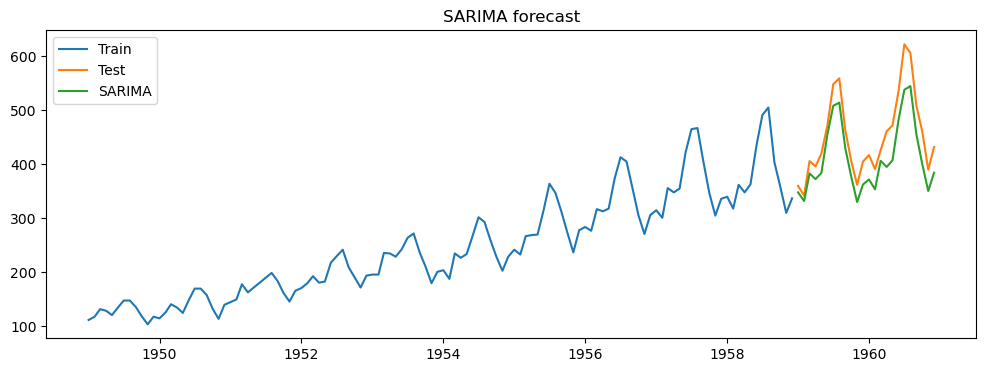

In [576]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'],label='Train')
plt.plot(test['Passengers'],label='Test')
plt.plot(y_hat_sarima['sarima_forecast'][test.index.min():],label = 'SARIMA')
plt.legend(loc='best')
plt.title('SARIMA forecast')
plt.show(block=False)

- Here we can see that along with the trend clearly seasonality has been also captured.

In [578]:
##rmse and mape
rmse  = round(np.sqrt(mean_squared_error(test['Passengers'],y_hat_sarima['sarima_forecast'][test.index.min():])),2)
mape = round(np.mean((np.abs(test['Passengers']-y_hat_sarima['sarima_forecast'][test.index.min():]))/test['Passengers']*100),2)
tempResults = pd.DataFrame({'Method':['SARIMA Method'],'RMSE':[rmse],'MAPE':[mape]})
results = pd.concat([results,tempResults])
results.reset_index(drop=True,inplace=True)
results

,Method,RMSE,MAPE
0,Naive Method,137.51,23.63
1,Simple Average Method,219.69,44.28
2,Simple Moving Average,103.33,15.54
3,Simple Exponential Smoothing,107.65,16.49
4,Holts Exponential Smoothing,80.91,11.39
5,Holts Winters Additive,35.87,6.72
6,Holts Winters Multiplicative,32.45,6.45
7,Simple Auto Regression(AR),96.97,14.43
8,Moving Average(MA),66.74,9.54
9,ARMA Method,91.38,13.21


- SARIMA is the comparitively more accurate than that of ARIMA, since it is capturing the seasonality also.

### SARIMA with exogenos variable(SARIMAX) 

In [579]:
promo =  pd.read_csv('promotion.csv',header=None)
promo.columns = ['Month','Event']
promo['Month'] = pd.to_datetime(promo['Month'],format="%Y-%m")
promo.set_index('Month',inplace=True)

In [580]:
promo

,Event
Month,
1949-01-01,0
1949-02-01,0
1949-03-01,0
1949-04-01,0
1949-05-01,0
...,...
1960-08-01,1
1960-09-01,1
1960-10-01,1


- 0- promotion did not take place
- 1- promotion take place

In [581]:
promo_train = promo[:train_len]
promo_test = promo[train_len:]

- Note we are also knowing the future promotion dates here.

In [582]:
model = SARIMAX(train_df_boxcox,order=(1,1,1),seasonal_order=(1,1,1,12),exog=promo_train)
model_fit = model.fit()
print(model_fit.params)

Event       0.111108
ar.L1       0.531701
ma.L1      -0.767025
ar.S.L12   -0.088996
ma.S.L12   -0.465901
sigma2      0.011846
dtype: float64


In [583]:
##Reversing the time series
y_hat_sarimax = df_boxcox_diff.copy()
y_hat_sarimax['sarimax_boxcox'] = model_fit.predict(df_boxcox_diff.index.min(),df_boxcox_diff.index.max(),exog=promo_test)
y_hat_sarimax['sarimax_forecast'] = inv_boxcox(y_hat_sarimax['sarimax_boxcox'],0.2)

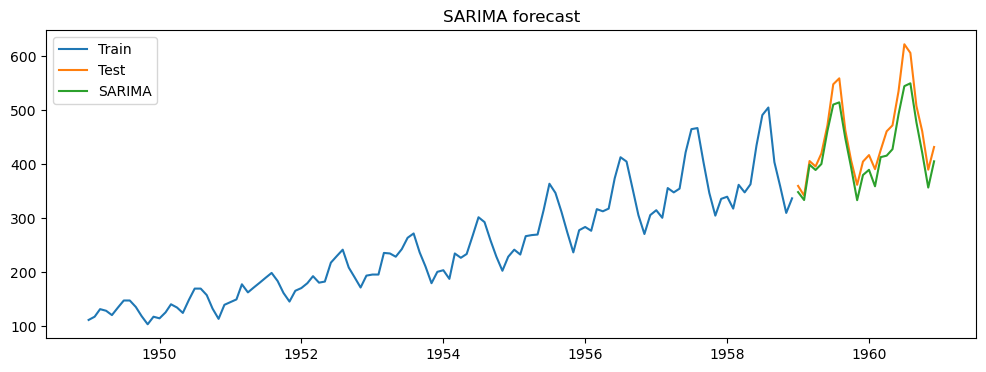

In [584]:
### plotting the graph
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'],label='Train')
plt.plot(test['Passengers'],label='Test')
plt.plot(y_hat_sarimax['sarimax_forecast'][test.index.min():],label = 'SARIMA')
plt.legend(loc='best')
plt.title('SARIMA forecast')
plt.show(block=False)

In [585]:
##rmse and mape
rmse  = round(np.sqrt(mean_squared_error(test['Passengers'],y_hat_sarimax['sarimax_forecast'][test.index.min():])),2)
mape = round(np.mean((np.abs(test['Passengers']-y_hat_sarimax['sarimax_forecast'][test.index.min():]))/test['Passengers']*100),2)
tempResults = pd.DataFrame({'Method':['SARIMAX Method'],'RMSE':[rmse],'MAPE':[mape]})
results = pd.concat([results,tempResults])
results.reset_index(drop=True,inplace=True)
results

,Method,RMSE,MAPE
0,Naive Method,137.51,23.63
1,Simple Average Method,219.69,44.28
2,Simple Moving Average,103.33,15.54
3,Simple Exponential Smoothing,107.65,16.49
4,Holts Exponential Smoothing,80.91,11.39
5,Holts Winters Additive,35.87,6.72
6,Holts Winters Multiplicative,32.45,6.45
7,Simple Auto Regression(AR),96.97,14.43
8,Moving Average(MA),66.74,9.54
9,ARMA Method,91.38,13.21


- SARIMAX is the best model we have captured comparitive to every other method.
- Seems like the exog is able to get us a more accurate prediction here.